In [11]:
import numpy as np
import matplotlib.pyplot as plt
from trng import LightRandom

In [12]:
lrng = LightRandom()
lrng

In [13]:
class Particle:
    def __init__(self, dim, bounds):
        self.position = lrng.uniform(bounds[0], bounds[1], dim)
        self.velocity = lrng.uniform(-1, 1, dim)
        self.best_position = self.position.copy()
        self.best_value = float('inf')

class PSO:
    def __init__(self, func, dim, num_particles=30, bounds=(-5, 5),
                 w=0.7, c1=1.5, c2=1.5, max_iter=100):
        self.func = func
        self.dim = dim
        self.num_particles = num_particles
        self.bounds = bounds
        self.w = w         
        self.c1 = c1        
        self.c2 = c2        
        self.max_iter = max_iter
        # Precompute r1 and r2: shape = (max_iter, num_particles, dim)
        # self.r1 = lrng.rand(self.max_iter, self.num_particles, self.dim)
        # self.r2 = lrng.rand(self.max_iter, self.num_particles, self.dim)


        self.swarm = [Particle(dim, bounds) for _ in range(num_particles)]
        self.gbest_position = lrng.uniform(bounds[0], bounds[1], dim)
        self.gbest_value = float('inf')
        self.gbest_history = []
        self.positions_history = []

    def optimize(self):
        for iter in range(self.max_iter):
            current_positions = []

            for particle in self.swarm:
                fitness = self.func(particle.position)

                if fitness < particle.best_value:
                    particle.best_value = fitness
                    particle.best_position = particle.position.copy()

                if fitness < self.gbest_value:
                    self.gbest_value = fitness
                    self.gbest_position = particle.position.copy()

                current_positions.append(particle.position.copy())

            self.positions_history.append(current_positions)
            self.gbest_history.append(self.gbest_position.copy())

            for i, particle in enumerate(self.swarm):
                r1 = np.random.rand(self.dim)
                r2 = np.random.rand(self.dim)



                cognitive = self.c1 * r1 * (particle.best_position - particle.position)
                social = self.c2 * r2 * (self.gbest_position - particle.position)

                particle.velocity = self.w * particle.velocity + cognitive + social
                particle.position += particle.velocity

                particle.position = np.clip(particle.position, self.bounds[0], self.bounds[1])

        return self.gbest_position, self.gbest_value

    def get_gbest_history(self):
        return self.gbest_history

    def get_positions_history(self):
        return self.positions_history


In [14]:
def sphere(x):
    return np.sum(x**2)

def rastrigin(x):
    A = 10
    return A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

def ackley(x):
    a = 20
    b = 0.2
    c = 2 * np.pi
    d = len(x)
    sum_sq = np.sum(x**2)
    sum_cos = np.sum(np.cos(c * x))
    term1 = -a * np.exp(-b * np.sqrt(sum_sq / d))
    term2 = -np.exp(sum_cos / d)
    return term1 + term2 + a + np.exp(1)

def rosenbrock(x):
    return np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

In [15]:
pso = PSO(func=rastrigin, dim=3, num_particles=50, max_iter=200, bounds=(-5.12, 5.12))
gbest_pos, gbest_val = pso.optimize()

print("Best position:", gbest_pos)
print("Best value:", gbest_val)

Best position: [-2.04001713e-09  6.76990852e-10  2.66399605e-09]
Best value: 0.0


In [21]:
plt.style.use("seaborn-v0_8-whitegrid")
dpi = 200
def plot_function_surface(func, bounds=(-5.12, 5.12), title="Function Surface"):
    fig = plt.figure(figsize=(10, 10), dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')

    X = np.linspace(bounds[0], bounds[1], 200)
    Y = np.linspace(bounds[0], bounds[1], 200)
    X, Y = np.meshgrid(X, Y)
    Z = np.array([func(np.array([x, y])) for x, y in zip(X.ravel(), Y.ravel())]).reshape(X.shape)

    ax.plot_surface(X, Y, Z, cmap='cubehelix', alpha=0.8, edgecolor='none')
    ax.set_title(title, fontsize=16, weight="bold")
    ax.set_xlabel("x", fontsize=12, weight="bold")
    ax.set_ylabel("y", fontsize=12, weight="bold")
    ax.set_zlabel("f(x, y)", fontsize=12, weight="bold")
    plt.tight_layout()
    plt.show()

def plot_convergence(gbest_history):
    values = [np.linalg.norm(g) for g in gbest_history]  # or just gbest_value if stored
    plt.figure(figsize=(10, 10), dpi=dpi)
    plt.plot(values, label='Global Best Value')
    plt.axhline(y=0, color='black', linewidth=1)  # X-axis line
    plt.axvline(x=0, color='black', linewidth=1)  # Y-axis line
    plt.xlabel("Iterations", fontsize=12, weight="bold")
    plt.ylabel("f(Global Best)", fontsize=12, weight="bold")
    plt.title("Convergence Over Iterations", fontsize=16, weight="bold")
    plt.grid(linestyle="--", alpha=0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_gbest_contour(pso, func, bounds=(-5.12, 5.12), title="GBest Path on Contour"):
    x = np.linspace(bounds[0], bounds[1], 400)
    y = np.linspace(bounds[0], bounds[1], 400)
    X, Y = np.meshgrid(x, y)
    Z = np.array([func(np.array([xi, yi])) for xi, yi in zip(X.ravel(), Y.ravel())]).reshape(X.shape)

    plt.figure(figsize=(10, 10), dpi=dpi)
    contour = plt.contourf(X, Y, Z, levels=100, cmap='cubehelix', alpha=0.8)
    plt.colorbar(contour)

    gbest_path = np.array(pso.get_gbest_history())
    if gbest_path.shape[1] >= 2:
        plt.plot(gbest_path[:, 0], gbest_path[:, 1], marker='o', color='white', linewidth=2, label='Global Best Path')
        plt.scatter(gbest_path[-1, 0], gbest_path[-1, 1], color='cyan', edgecolors='black', zorder=5, label='Final GBest')
    else:
        print("Error: Global best path is not 2D — this plot is only for dim=2.")

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


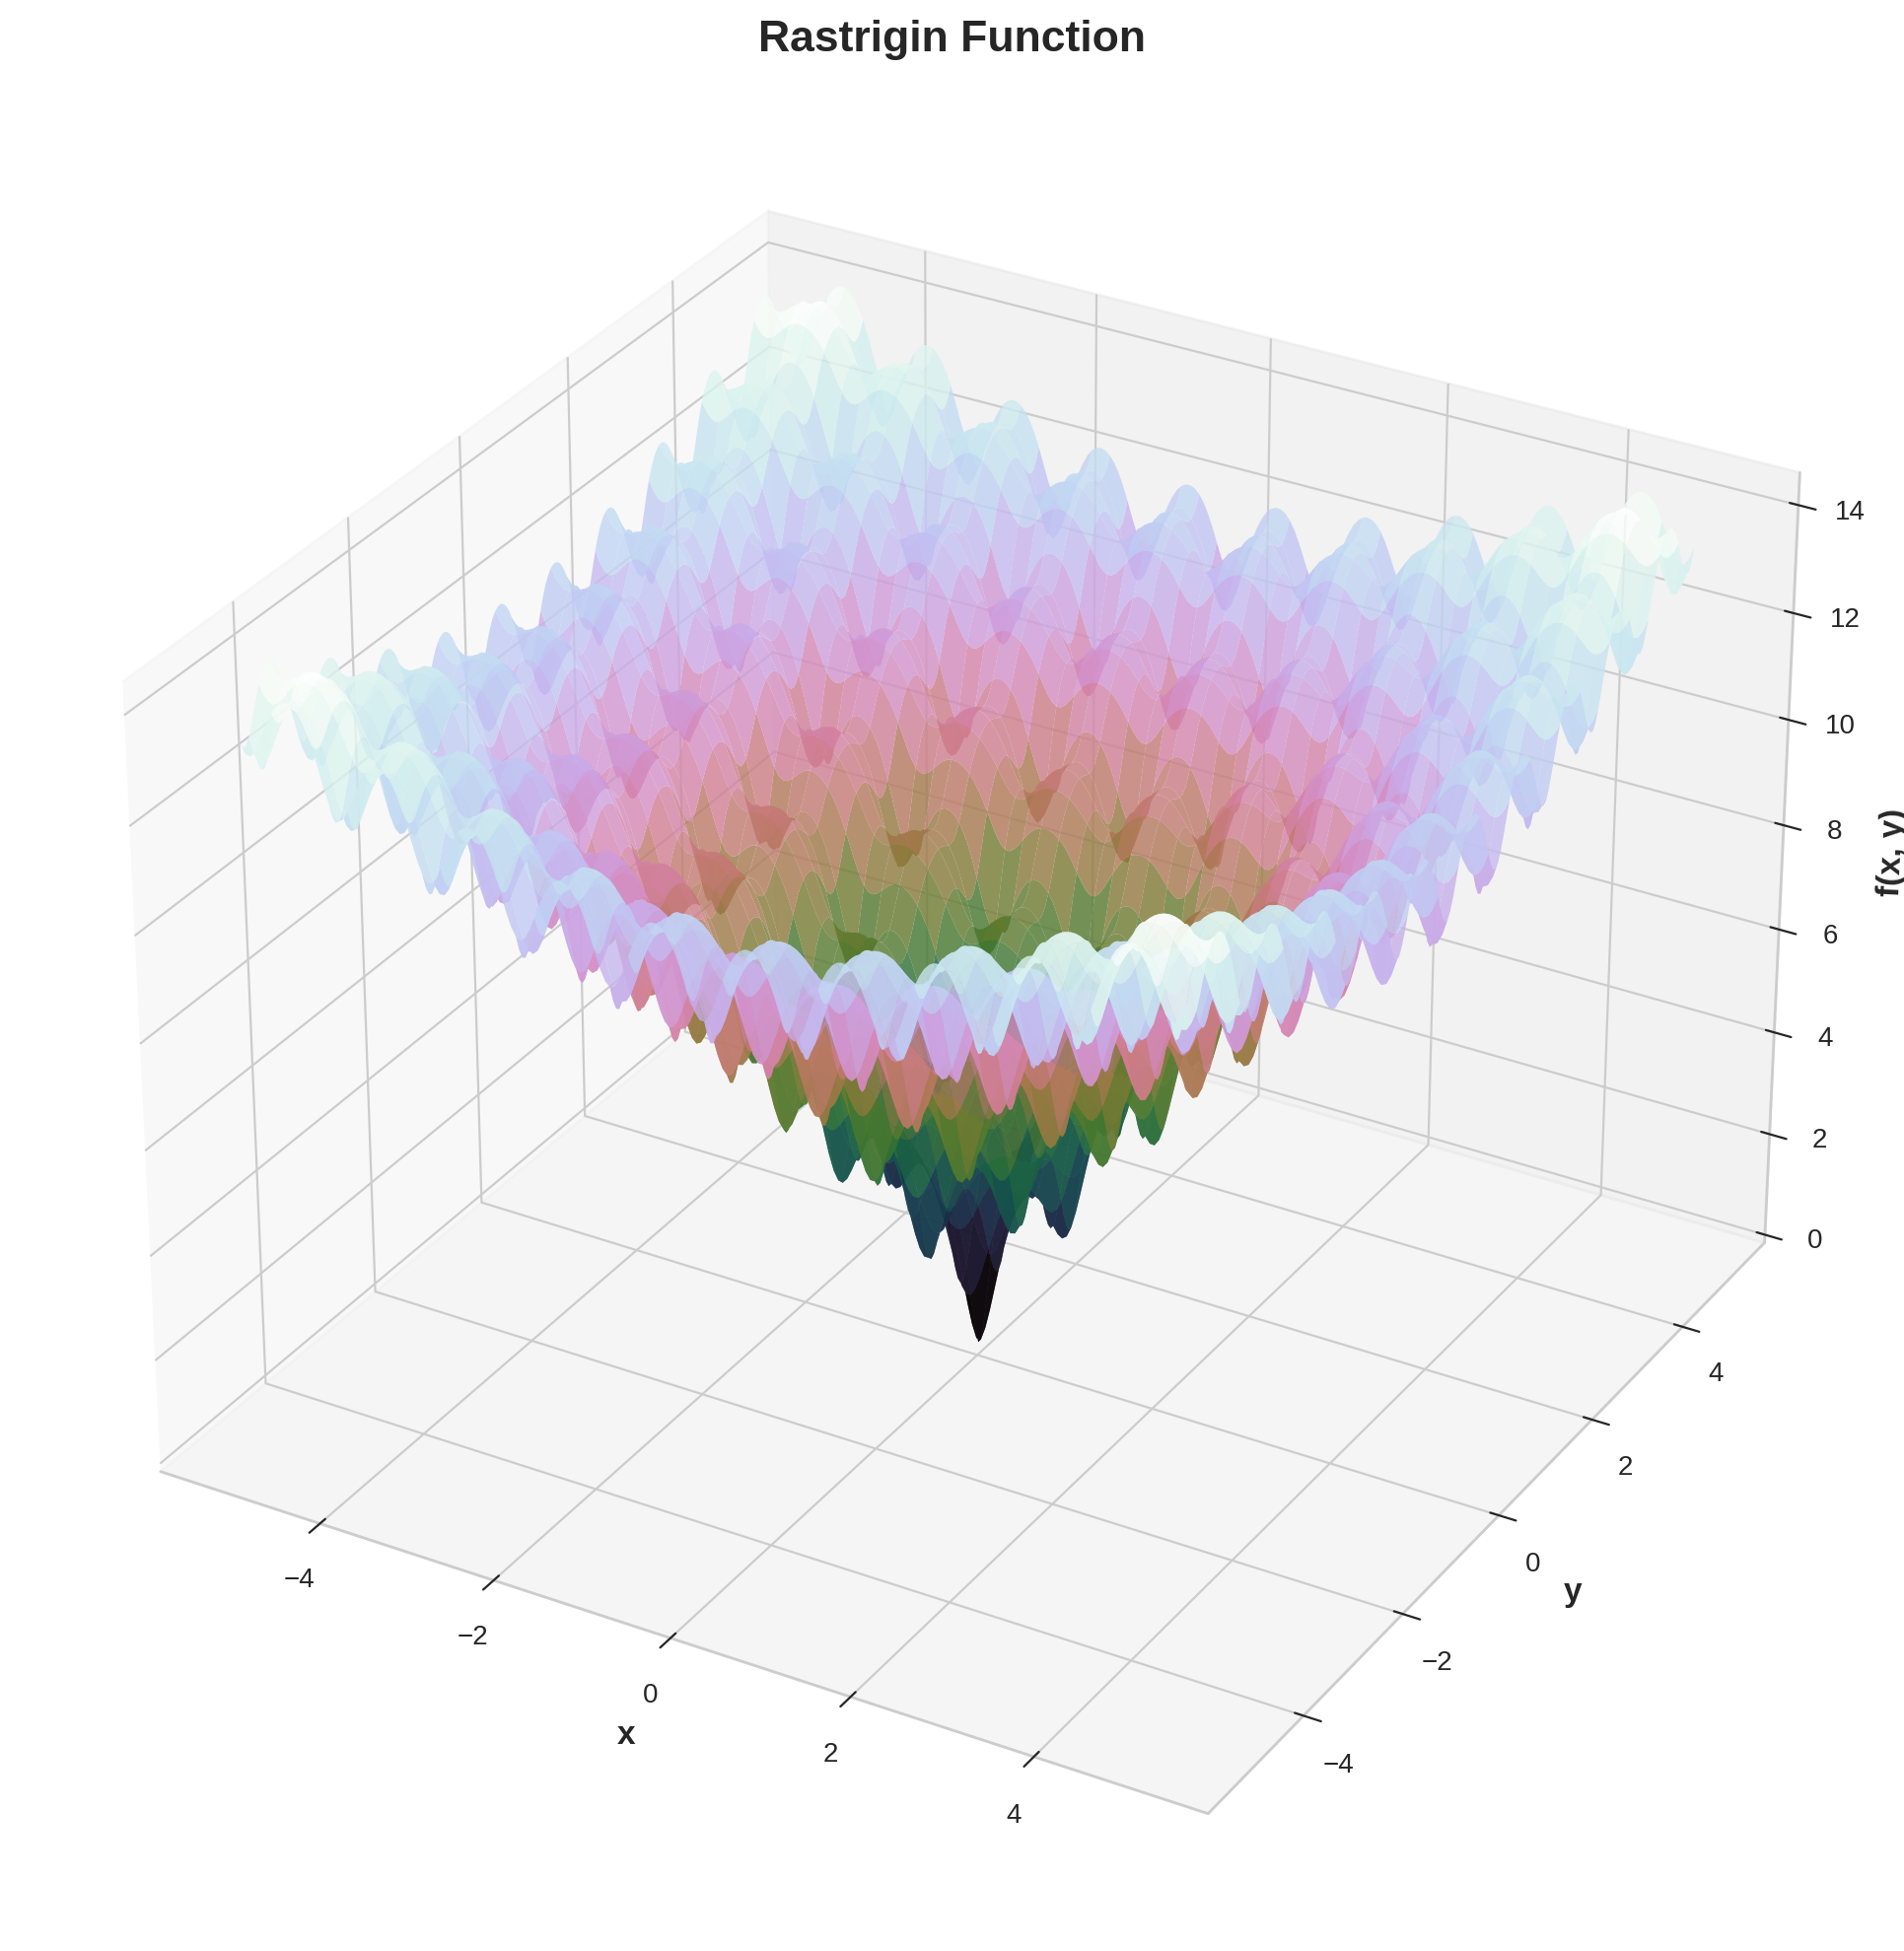

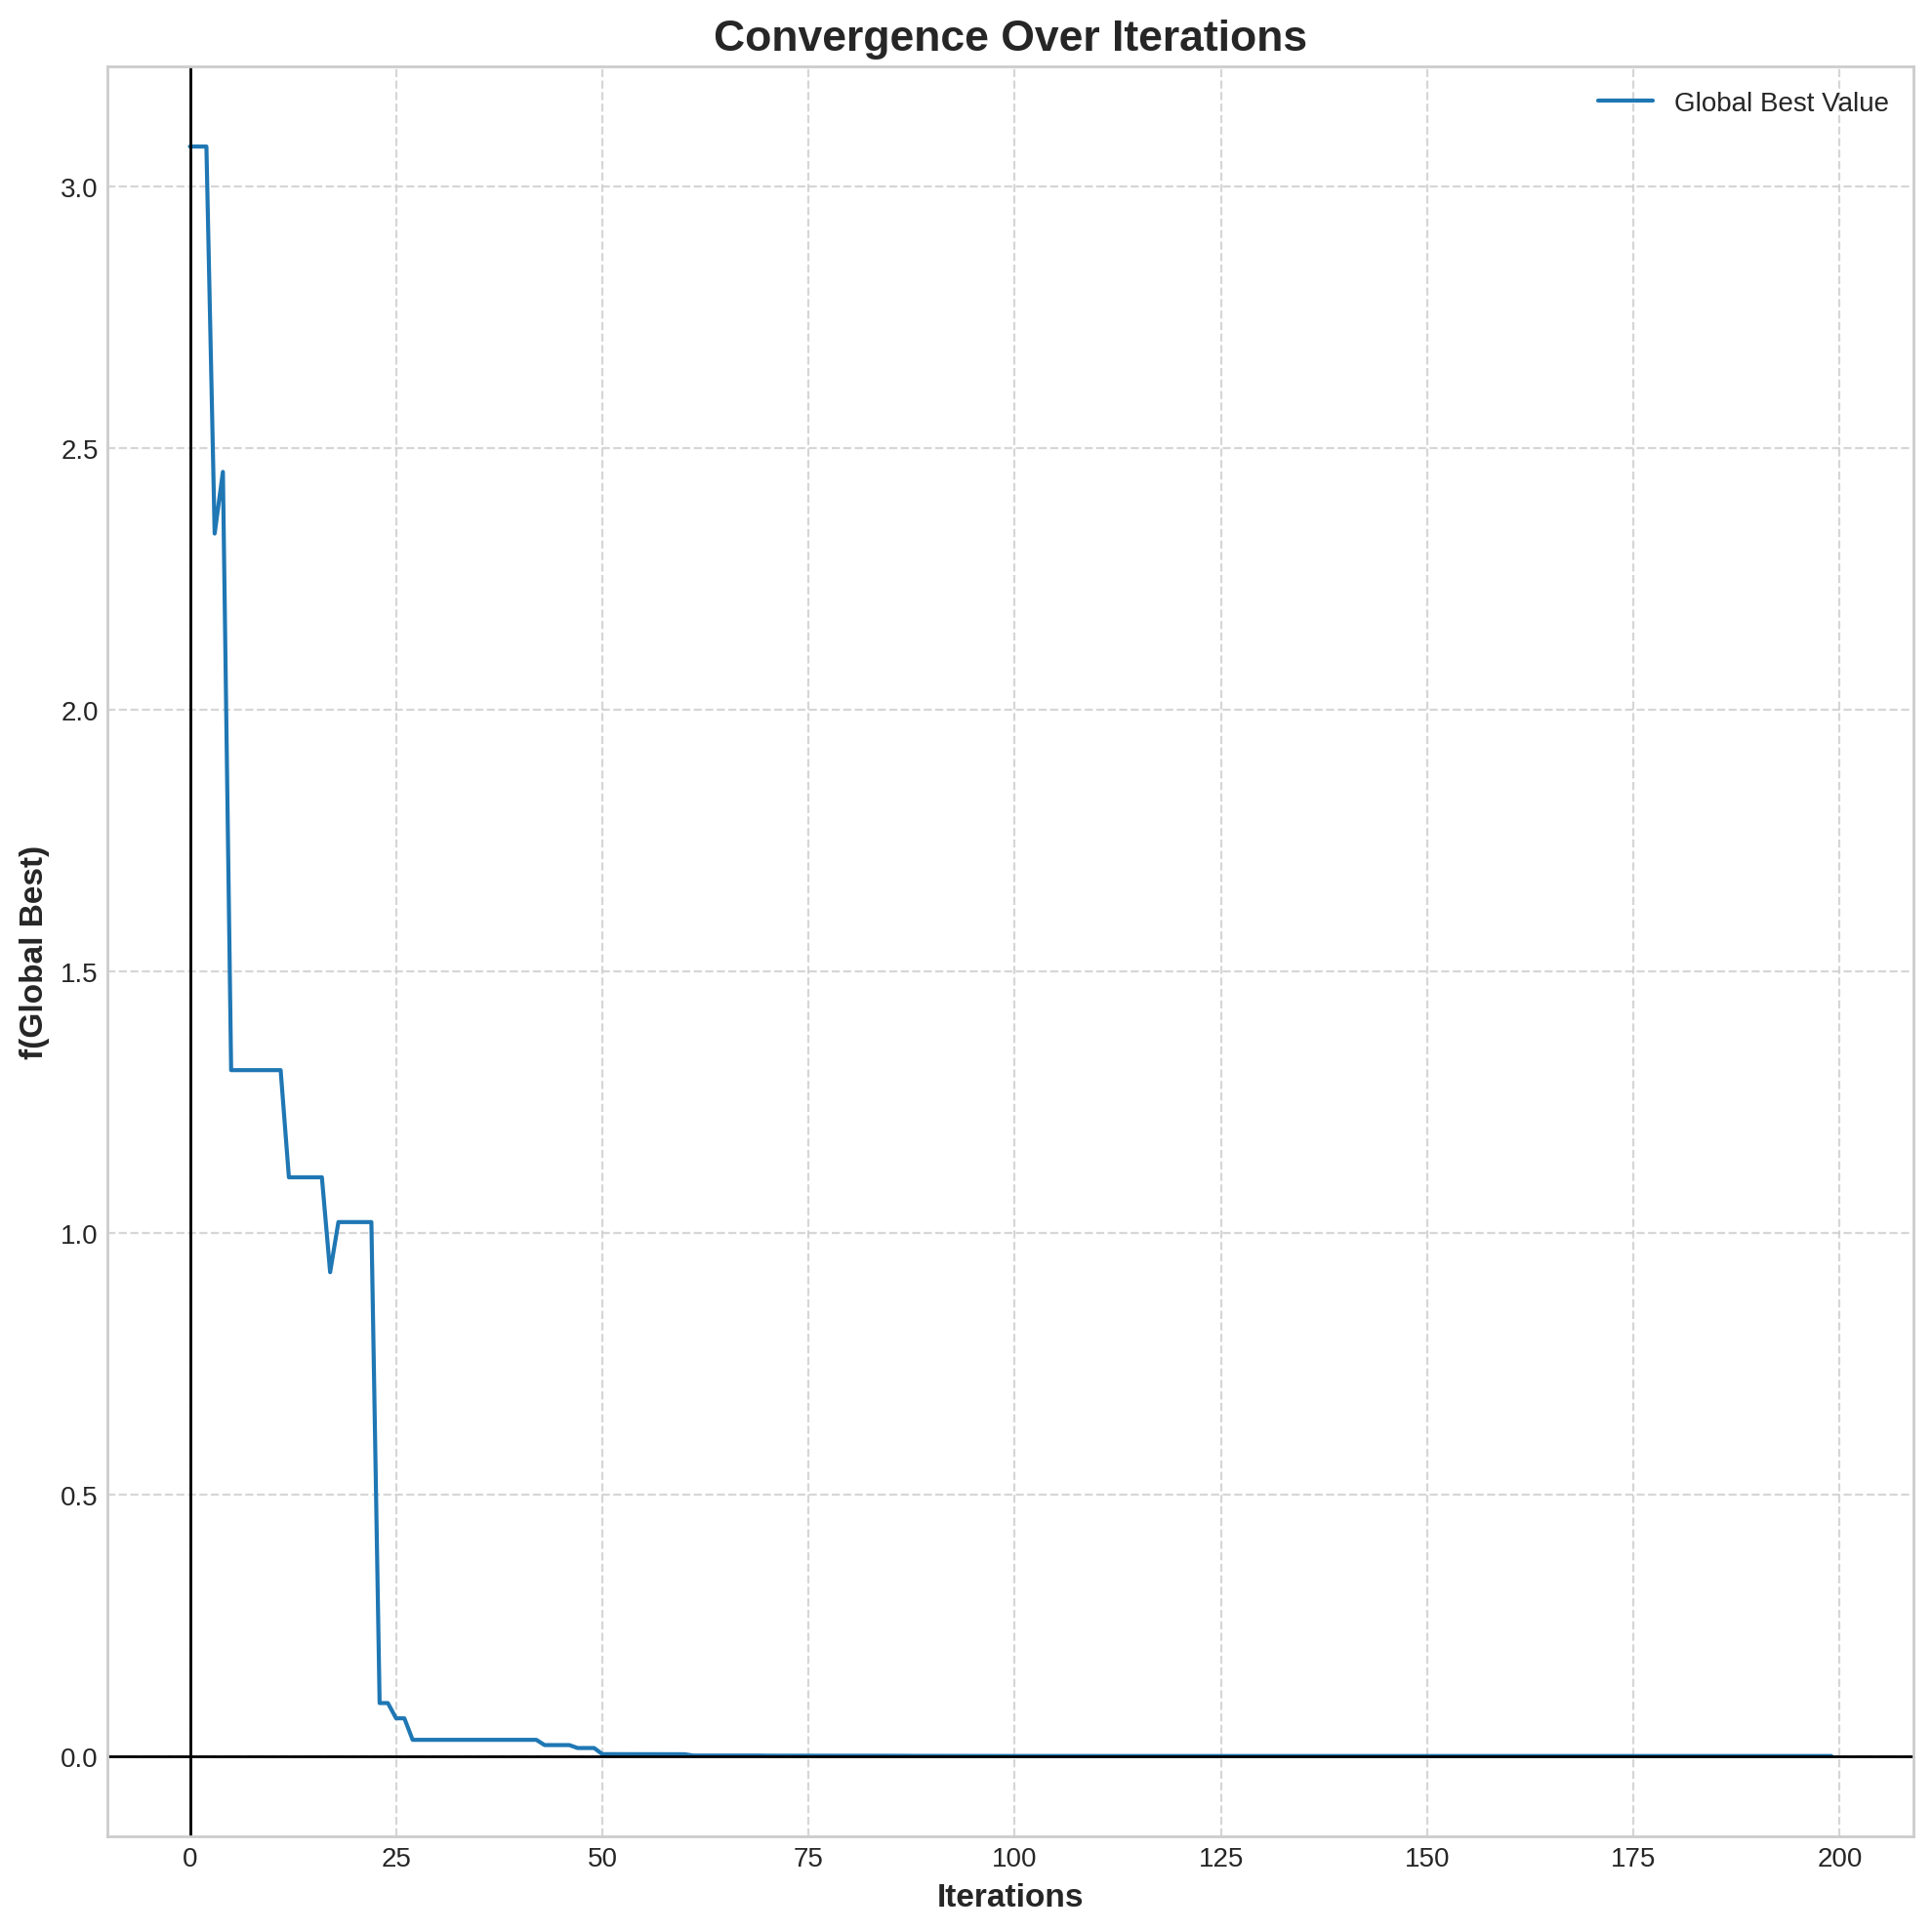

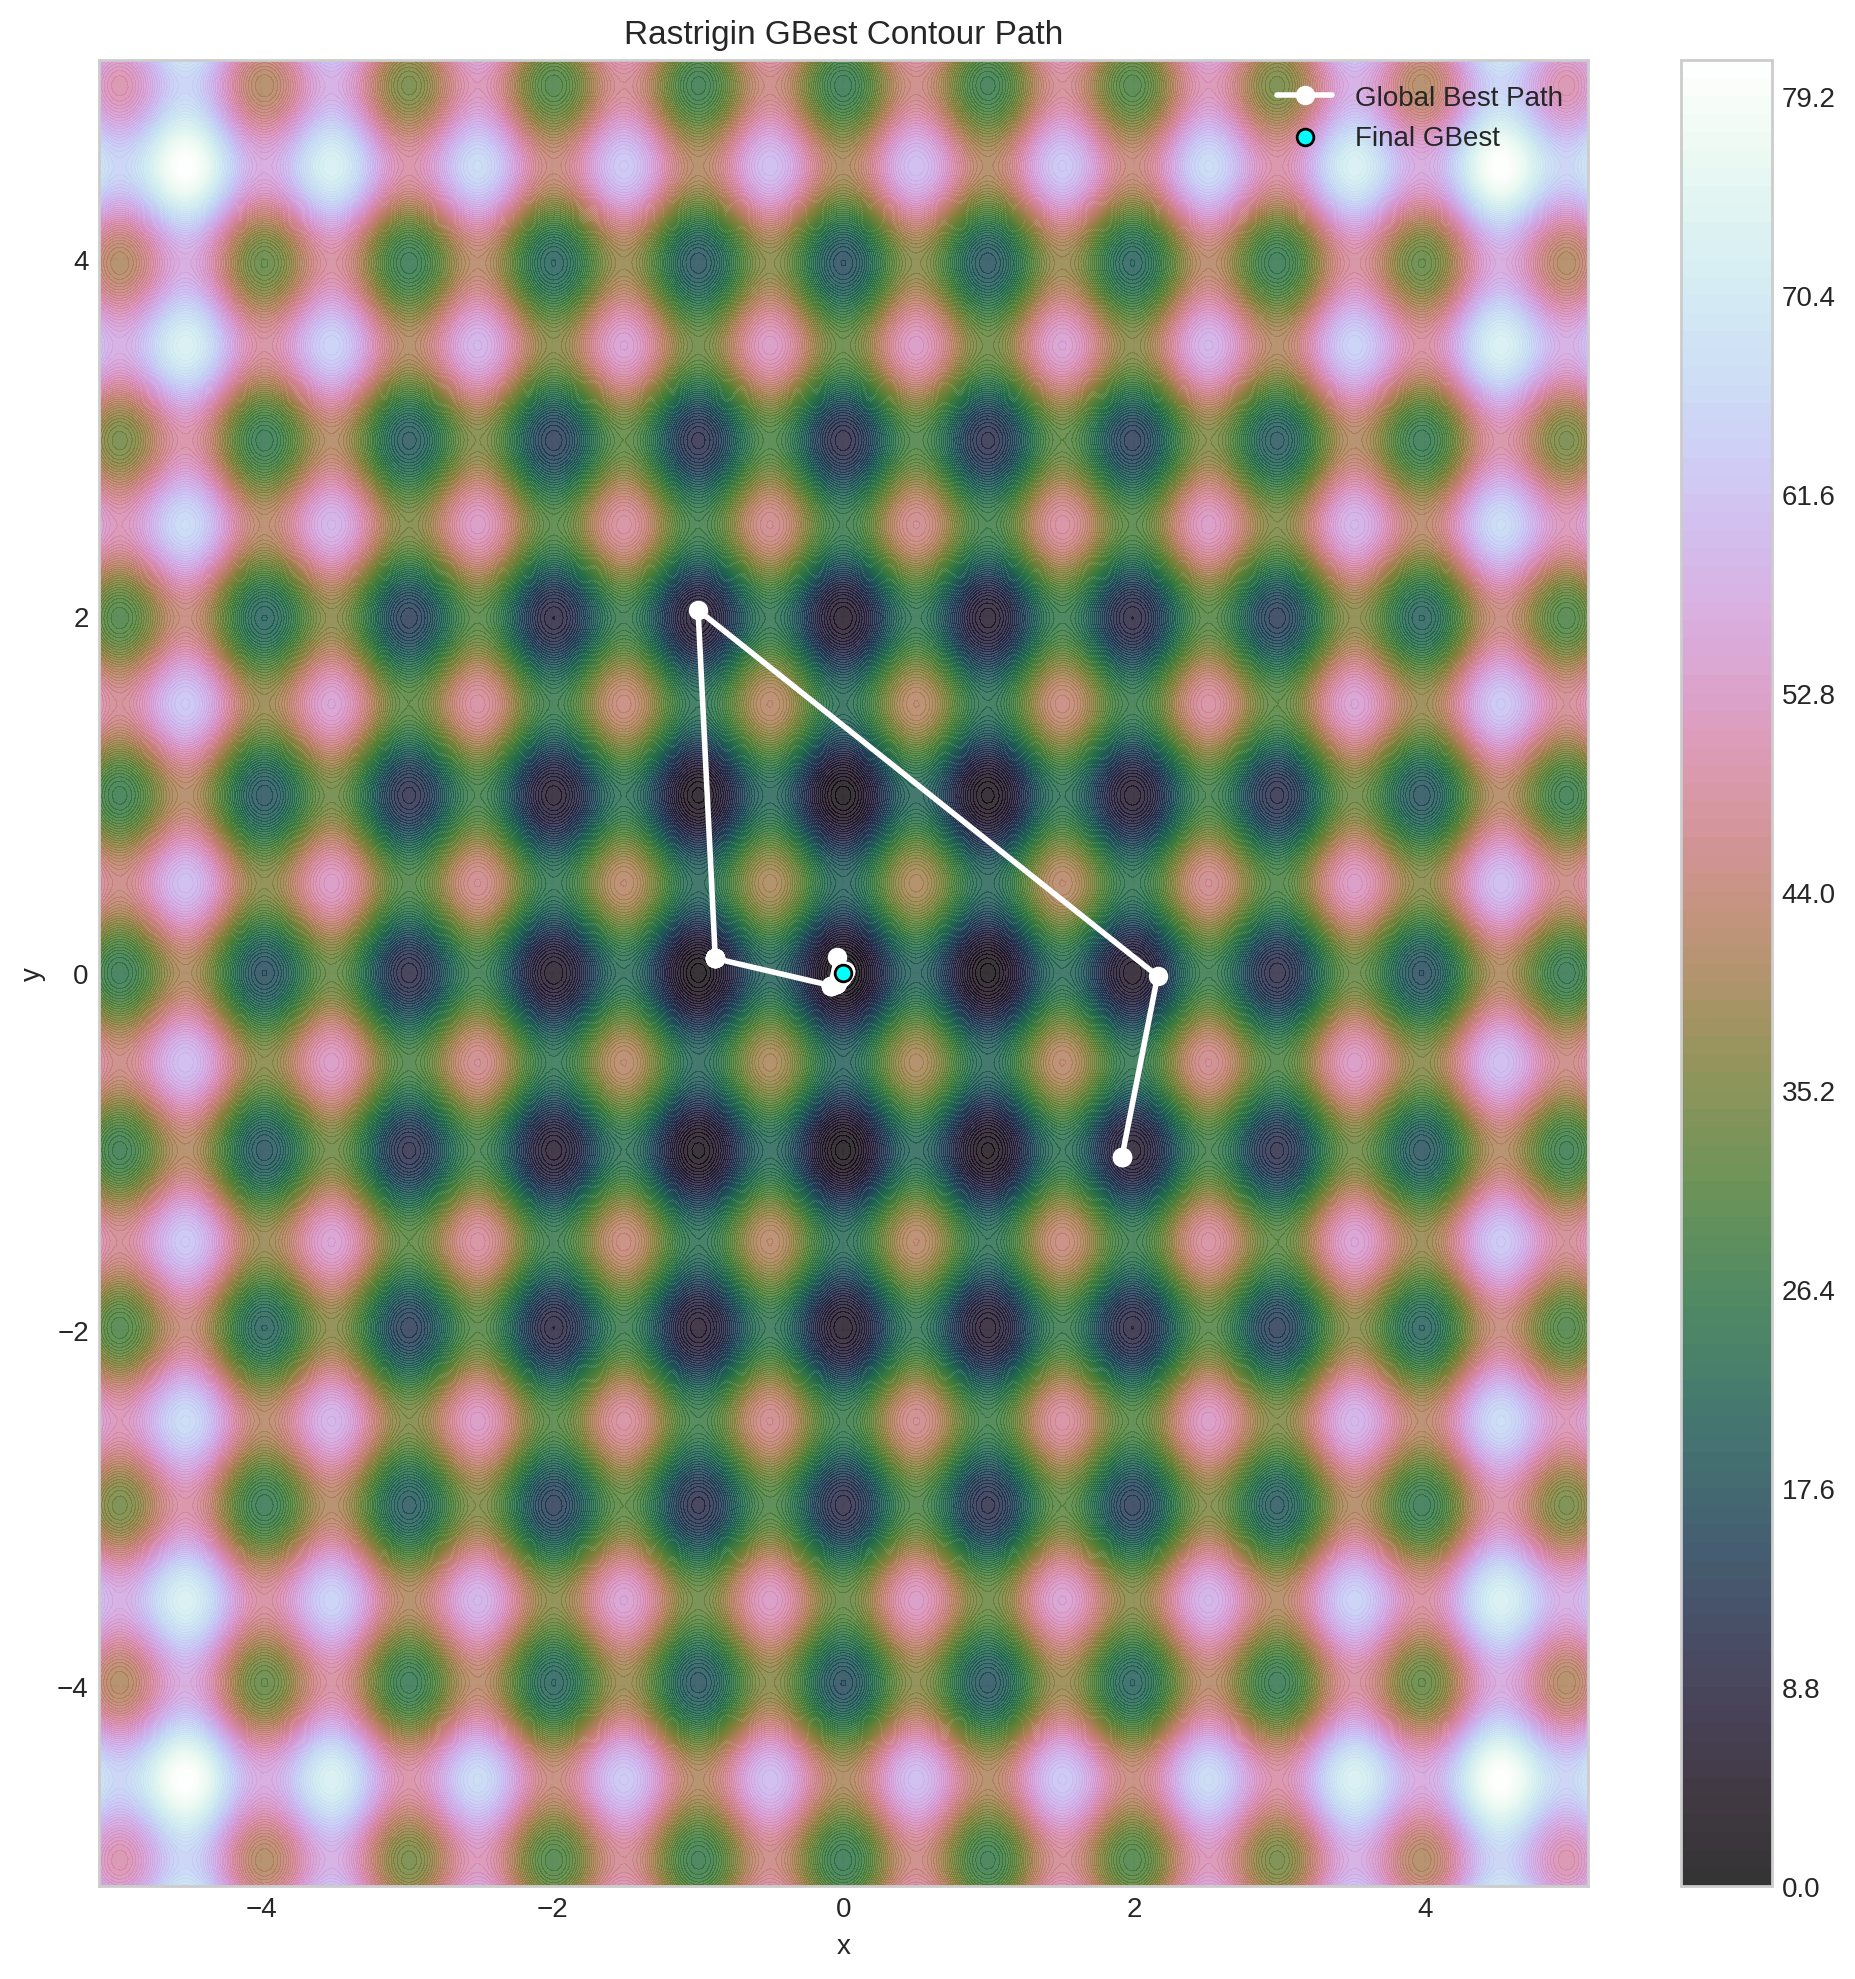

In [22]:
func = ackley
bounds = (-5.12, 5.12)
plot_function_surface(func, bounds=bounds, title="Rastrigin Function")
plot_convergence(pso.get_gbest_history())
plot_gbest_contour(pso, rastrigin, bounds=(-5.12, 5.12), title="Rastrigin GBest Contour Path")